In [1]:
import sys
sys.path.append('src/utils')

In [2]:
import preprocessing as prep
import glicko as glk
import elo as elo
import age as age
import h2h_metrics as h2h
import serve as serve
import pandas as pd

In [3]:
df = prep.load_data()
df = prep.get_target(df)

Successfully concatenated 25 files.
Combined DataFrame shape: (74906, 49)
  tourney_id tourney_name surface  draw_size tourney_level  tourney_date  \
0   2000-301     Auckland    Hard         32             A      20000110   
1   2000-301     Auckland    Hard         32             A      20000110   
2   2000-301     Auckland    Hard         32             A      20000110   
3   2000-301     Auckland    Hard         32             A      20000110   
4   2000-301     Auckland    Hard         32             A      20000110   

   match_num  winner_id  winner_seed winner_entry  ... l_1stIn l_1stWon  \
0          1     103163          1.0          NaN  ...    55.0     39.0   
1          2     102607          NaN            Q  ...    32.0     25.0   
2          3     103252          NaN          NaN  ...    33.0     20.0   
3          4     103507          7.0          NaN  ...    43.0     29.0   
4          5     102103          NaN            Q  ...    46.0     34.0   

   l_2ndWon l_SvGm

In [25]:
df = glk.calculate_global_glicko_1(df)

In [26]:
df = glk.c_surface_glicko_1(df)

In [32]:
df = glk.c_general_glicko_2(df)

In [33]:
df = glk.c_surface_glicko_2(df)


Row 0: A=103096, B=102358, Surface=Hard, Target=0
Initial A: R=1200.00, RD=350.00
Initial B: R=1200.00, RD=350.00
Assigned A_Rating at index 0: 1200.00
New A_Rating for next match: 1031.05

Row 1: A=101543, B=103017, Surface=Hard, Target=0
Initial A: R=1200.00, RD=350.00
Initial B: R=1200.00, RD=350.00
Assigned A_Rating at index 1: 1200.00
New A_Rating for next match: 1031.05

Row 2: A=103420, B=102338, Surface=Hard, Target=1
Initial A: R=1200.00, RD=350.00
Initial B: R=1200.00, RD=350.00
Assigned A_Rating at index 2: 1200.00
New A_Rating for next match: 1368.95

Row 3: A=103819, B=102533, Surface=Hard, Target=1
Initial A: R=1200.00, RD=350.00
Initial B: R=1200.00, RD=350.00
Assigned A_Rating at index 3: 1200.00
New A_Rating for next match: 1368.95

Row 4: A=101750, B=102730, Surface=Hard, Target=1
Initial A: R=1200.00, RD=350.00
Initial B: R=1200.00, RD=350.00
Assigned A_Rating at index 4: 1200.00
New A_Rating for next match: 1368.95


In [27]:
df = h2h.h2h_totals(df)

In [28]:
df = h2h.h2h_surface_totals(df)

In [29]:
df = h2h.h2h_streak(df)

In [30]:
df = h2h.h2h_level_weighted(df)

In [31]:
df = age.add_age_optimality_features(df)

In [4]:
df = elo.calculate_general_elo(df)
df = elo.calculate_surface_elo(df)

In [5]:
df_elo = df[['tourney_date', 'player_A_id', 'player_A_name', 'player_B_id', 'player_B_name', 'A_Elo_Overall', 'B_Elo_Overall']]

In [6]:
df_elo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74906 entries, 0 to 74905
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   tourney_date   74906 non-null  datetime64[ns]
 1   player_A_id    74906 non-null  int64         
 2   player_A_name  74906 non-null  object        
 3   player_B_id    74906 non-null  int64         
 4   player_B_name  74906 non-null  object        
 5   A_Elo_Overall  74906 non-null  float64       
 6   B_Elo_Overall  74906 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 4.0+ MB


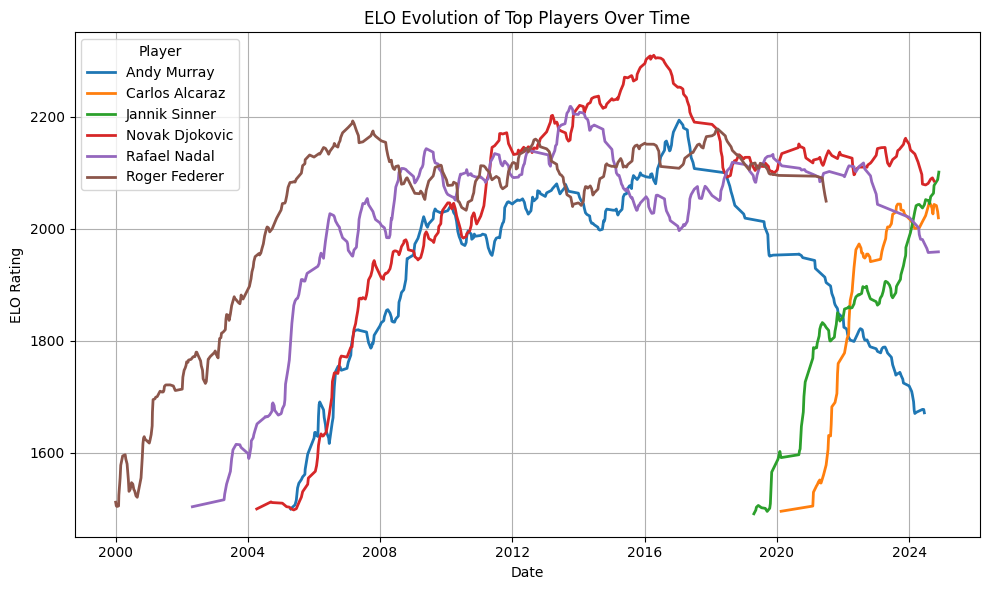

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1) Prepare the dataset ---
df = df_elo.copy()

# Stack A/B players into one long table
a = df[['tourney_date', 'player_A_id', 'player_A_name', 'A_Elo_Overall']].rename(
    columns={'player_A_id':'player_id', 'player_A_name':'player_name', 'A_Elo_Overall':'Elo'}
)
b = df[['tourney_date', 'player_B_id', 'player_B_name', 'B_Elo_Overall']].rename(
    columns={'player_B_id':'player_id', 'player_B_name':'player_name', 'B_Elo_Overall':'Elo'}
)
long = pd.concat([a, b], ignore_index=True)

# Sort and smooth for visual clarity (optional)
long = long.sort_values(['player_id', 'tourney_date'])
long['Elo_smooth'] = (
    long.groupby('player_id', group_keys=False)['Elo']
        .apply(lambda s: s.rolling(5, min_periods=1).mean())
)

# --- 2) Identify top N players by their peak Elo ---
N = 6
peaks = (long.groupby(['player_id','player_name'])['Elo_smooth']
              .max()
              .reset_index()
              .sort_values('Elo_smooth', ascending=False))
top_players = peaks.head(N)
top_ids = set(top_players['player_id'])

# Filter dataset to top players only
top_data = long[long['player_id'].isin(top_ids)].copy()

# Aggregate to one Elo value per player per date (mean avoids duplicate date issues)
top_data = (top_data
            .groupby(['player_id','player_name','tourney_date'], as_index=False)['Elo_smooth']
            .mean())

# --- 3) Plot the ELO evolution ---
plt.figure(figsize=(10, 6))
for name, g in top_data.groupby('player_name'):
    plt.plot(g['tourney_date'], g['Elo_smooth'], label=name, linewidth=2)

plt.title('ELO Evolution of Top Players Over Time')
plt.xlabel('Date')
plt.ylabel('ELO Rating')
plt.legend(title="Player", loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


In [37]:
df = serve.serve_statistics_averages(df)

In [12]:
for col in df.columns:
    print(col+', ', end='')

tourney_id, tourney_name, surface, tourney_level, tourney_date, match_num, player_A_id, player_A_seed, player_A_entry, player_A_name, player_A_hand, player_A_ht, player_A_ioc, player_A_age, player_B_id, player_B_seed, player_B_entry, player_B_name, player_B_hand, player_B_ht, player_B_ioc, player_B_age, score, best_of, round, minutes, player_A_ace, player_A_df, player_A_svpt, player_A_1stIn, player_A_1stWon, player_A_2ndWon, player_A_SvGms, player_A_bpSaved, player_A_bpFaced, player_B_ace, player_B_df, player_B_svpt, player_B_1stIn, player_B_1stWon, player_B_2ndWon, player_B_SvGms, player_B_bpSaved, player_B_bpFaced, player_A_rank, player_A_rank_points, player_B_rank, player_B_rank_points, target, A_Glicko1_Rating, B_Glicko1_Rating, A_Glicko1_RD, B_Glicko1_RD, A_Glicko1_Surface_Rating, B_Glicko1_Surface_Rating, A_Glicko1_Surface_RD, B_Glicko1_Surface_RD, A_H2H_Total_Matches, B_H2H_Total_Matches, A_H2H_Wins, B_H2H_Wins, A_H2H_Surface_Matches, B_H2H_Surface_Matches, A_H2H_Surface_Wins, B

In [13]:
df['same_hand'] = (df['player_A_hand'] == df['player_B_hand']).astype(int)
df['height_diff'] = df['player_A_ht'] - df['player_B_ht']
df['rank_diff'] = df['player_A_rank'] - df['player_B_rank']
df['rank_points_diff'] = df['player_A_rank_points'] - df['player_B_rank_points']
df['glicko_diff'] = df['A_Glicko1_Rating'] - df['B_Glicko1_Rating']
df['glicko_surface_diff'] = df['A_Glicko1_Surface_Rating'] - df['B_Glicko1_Surface_Rating']
df['hybrid_glicko_diff'] = (0.5*df['A_Glicko1_Rating'] * 0.5*df['A_Glicko1_Surface_Rating']) - (0.5*df['B_Glicko1_Rating'] + 0.5*df['B_Glicko1_Surface_Rating'])
df['h2h_wins_diff'] = (df['A_H2H_Wins'] - df['A_H2H_Wins']) / (df['A_H2H_Total_Matches'] + df['B_H2H_Total_Matches'])
df['h2h_surface_wins_diff'] = (df['A_H2H_Surface_Wins'] - df['B_H2H_Surface_Wins']) / (df['A_H2H_Surface_Matches'] + df['B_H2H_Surface_Matches'])
df['h2h_streak_diff'] = df['A_H2H_Streak'] - df['B_H2H_Streak']
df['h2h_level_weighted_diff'] = (df['A_H2H_LevelWeighted_Wins'] - df['B_H2H_LevelWeighted_Wins'])
df['hybrid_elo_diff'] = (0.5*df['A_Elo_Overall'] * 0.5*df['A_Elo_Surface']) - (0.5*df['B_Elo_Overall'] + 0.5*df['B_Elo_Surface'])
df['elo_overall_diff'] = df['A_Elo_Overall'] - df['B_Elo_Overall']
df['elo_surface_diff'] = df['A_Elo_Surface'] - df['B_Elo_Surface']

In [14]:
columns = [
    'surface',
    'tourney_date',
    'best_of',
    'tourney_level',
    'same_hand',
    'height_diff',
    'rank_diff',
    'rank_points_diff',
    'hybrid_glicko_diff',
    'glicko_diff',
    'glicko_surface_diff',
    'h2h_streak_diff',
    'h2h_level_weighted_diff',
    'Age30_Diff',
    'AgeInt_Diff',
    'elo_overall_diff',
    'player_A_id',
    'player_B_id',
    'elo_surface_diff',
    'target'
    ]
df_filtered = df.copy()[columns]

In [35]:
columns_gnn = [
    'surface',
    'tourney_date',
    'best_of',
    'tourney_level',
    'player_A_hand',
    'player_B_hand',
    'player_A_ht',
    'player_B_ht',
    'player_A_rank',
    'player_B_rank',
    'player_A_rank_points',
    'player_B_rank_points',
    'A_Glicko1_Rating',
    'B_Glicko1_Rating',
    'A_Glicko1_Surface_Rating',
    'B_Glicko1_Surface_Rating',
    'A_H2H_Streak',
    'B_H2H_Streak',
    'A_H2H_LevelWeighted_Wins',
    'B_H2H_LevelWeighted_Wins',
    'A_Age30',
    'B_Age30',
    'A_AgeInt',
    'B_AgeInt',
    'A_Elo_Overall',
    'B_Elo_Overall',
    'A_Elo_Surface',
    'B_Elo_Surface',
    'player_A_id',
    'player_B_id',
    'target'
    ]
df_gnn = df.copy()[columns_gnn]

In [38]:
df_gnn.info()
df_gnn.to_csv('df_gnn.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74906 entries, 0 to 74905
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   surface                   74853 non-null  object 
 1   tourney_date              74906 non-null  int64  
 2   best_of                   74906 non-null  int64  
 3   tourney_level             74906 non-null  object 
 4   player_A_hand             74903 non-null  object 
 5   player_B_hand             74905 non-null  object 
 6   player_A_ht               72780 non-null  float64
 7   player_B_ht               72698 non-null  float64
 8   player_A_rank             73890 non-null  float64
 9   player_B_rank             73881 non-null  float64
 10  player_A_rank_points      73890 non-null  float64
 11  player_B_rank_points      73881 non-null  float64
 12  A_Glicko1_Rating          74906 non-null  float64
 13  B_Glicko1_Rating          74906 non-null  float64
 14  A_Glic

In [24]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, drop='first')

df_filtered_encoded = ohe.fit_transform(df_filtered[['surface', 'best_of', 'tourney_level']])

encoded_cols = ohe.get_feature_names_out(['surface', 'best_of', 'tourney_level'])

df_encoded = pd.DataFrame(df_filtered_encoded, columns=encoded_cols, index=df_filtered.index)

df_final = pd.concat([df_filtered.drop(['surface', 'best_of', 'tourney_level'], axis=1), df_encoded], axis=1)


In [25]:
df_final

,same_hand,height_diff,rank_diff,rank_points_diff,hybrid_glicko_diff,h2h_streak_diff,h2h_level_weighted_diff,Age30_Diff,AgeInt_Diff,target,surface_Clay,surface_Grass,surface_Hard,surface_nan,best_of_5,tourney_level_D,tourney_level_F,tourney_level_G,tourney_level_M,tourney_level_O
0,1,-17.0,52.0,-1801.0,358800.000000,0,0.0,3.7,3.7,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,-3.0,49.0,-1633.0,358800.000000,0,0.0,-6.6,-5.6,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,-15.0,121.0,-3091.0,358800.000000,0,0.0,5.5,5.5,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,-5.0,-27.0,224.0,358800.000000,0,0.0,6.5,6.5,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,-10.0,-8.0,5.0,358800.000000,0,0.0,-5.7,-4.2,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74901,0,5.0,-102.0,1862.0,792214.879530,1,4.0,-1.5,-1.5,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
74902,1,-8.0,-28.0,1219.0,727845.651971,0,0.0,-1.3,-1.3,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
74903,0,13.0,-81.0,752.0,796951.911882,0,0.0,-1.3,-1.3,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
74904,1,7.0,17.0,-62.0,767384.036158,0,0.0,2.2,2.2,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [60]:
df = df.copy().dropna()

In [61]:
df

,tourney_id,tourney_name,surface,tourney_level,tourney_date,match_num,player_A_id,player_A_seed,player_A_entry,player_A_name,...,AgeInt_Diff,same_hand,height_diff,rank_diff,rank_points_diff,hybrid_glicko_diff,h2h_wins_diff,h2h_surface_wins_diff,h2h_streak_diff,h2h_level_weighted_diff


In [44]:
df.head()

,tourney_id,tourney_name,surface,tourney_level,tourney_date,match_num,player_A_id,player_A_seed,player_A_entry,player_A_name,...,A_first_in_pct,B_first_in_pct,A_first_win_pct,B_first_win_pct,A_second_win_pct,B_second_win_pct,A_serve_pts_won_pct,B_serve_pts_won_pct,A_bp_saved_pct,B_bp_saved_pct
0,2000-339,Adelaide,Hard,A,20000103,1,103096,NaN,NaN,Arnaud Clement,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,2000-451,Doha,Hard,A,20000103,1,101543,NaN,NaN,Jeff Tarango,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,2000-891,Chennai,Hard,A,20000103,1,103420,NaN,NaN,Michal Tabara,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,2000-339,Adelaide,Hard,A,20000103,2,103819,NaN,NaN,Roger Federer,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,2000-451,Doha,Hard,A,20000103,2,101750,NaN,Q,Cristiano Caratti,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [56]:
df_filtered.columns

Index(['surface', 'tourney_date', 'best_of', 'tourney_level', 'same_hand',
       'height_diff', 'rank_diff', 'rank_points_diff', 'hybrid_glicko_diff',
       'glicko_diff', 'glicko_surface_diff', 'h2h_streak_diff',
       'h2h_level_weighted_diff', 'Age30_Diff', 'AgeInt_Diff',
       'elo_overall_diff', 'player_A_id', 'player_B_id', 'elo_surface_diff',
       'target'],
      dtype='object')

In [15]:
import re
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score
from xgboost import XGBClassifier

In [16]:
df_model = df_filtered.copy()
df_model = df_model[~df_model['target'].isna()].reset_index(drop=True)
df_model['__dt'] = pd.to_datetime(df_model['tourney_date'].astype(str), format='%Y%m%d', errors='coerce')
df_model = df_model.loc[~df_model['__dt'].isna()].sort_values(['__dt', 'match_num' if 'match_num' in df_model.columns else '__dt']).reset_index(drop=True)

split_idx = int(0.8 * len(df_model))
df_train = df_model.iloc[:split_idx].copy()
df_valid = df_model.iloc[split_idx:].copy()

In [51]:
# 3) Categorical list (all pre-match)
CATEGORICAL_COLS = [c for c in [
    'surface','best_of','tourney_level'
]]

# 4) Build X, y with OHE for categoricals; coerce numerics; ensure no objects
y_train = df_train['target'].astype(int).values
y_valid = df_valid['target'].astype(int).values

feature_cols = [c for c in df_model.columns if c != '__dt' and c != 'target']
cat_cols = [c for c in CATEGORICAL_COLS if c in feature_cols]
num_cols = [c for c in feature_cols if c not in cat_cols]

# Coerce numerics (keeps NaN where needed)
df_train[num_cols] = df_train[num_cols].apply(pd.to_numeric, errors='coerce')
df_valid[num_cols]  = df_valid[num_cols].apply(pd.to_numeric, errors='coerce')

# One-hot encode categoricals (dummy_na to retain rows)
X_train = pd.get_dummies(df_train[num_cols + cat_cols], columns=cat_cols, dummy_na=True)
X_valid = pd.get_dummies(df_valid[num_cols + cat_cols], columns=cat_cols, dummy_na=True)

# Align and cast to float32
X_train, X_valid = X_train.align(X_valid, join='left', axis=1, fill_value=0)
X_train = X_train.replace([np.inf, -np.inf], np.nan).astype(np.float32)
X_valid = X_valid.replace([np.inf, -np.inf], np.nan).astype(np.float32)

corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X_train.drop(columns=to_drop, inplace=True)
X_valid.drop(columns=to_drop, inplace=True)

# 6) Fit XGBoost
xgb = XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.7,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=2.0,
    gamma=0.1,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)

# 7) Quick evaluation
proba = xgb.predict_proba(X_valid)[:, 1]
pred = (proba >= 0.5).astype(int)
print("Validation metrics")
print(f"  AUC:     {roc_auc_score(y_valid, proba):.4f}")
print(f"  LogLoss: {log_loss(y_valid, proba):.4f}")
print(f"  Acc:     {accuracy_score(y_valid, pred):.4f}")

# 8) XGBoost gain importance
booster = xgb.get_booster()
imp_gain = (pd.Series(booster.get_score(importance_type='gain'))
              .rename_axis("feature")
              .reset_index(name="gain")
              .sort_values("gain", ascending=False))
print("\nTop 30 features by XGBoost gain:")
display(imp_gain.head(30))

# 9) Permutation importance (model-agnostic)
perm = permutation_importance(
    xgb, X_valid, y_valid, scoring='neg_log_loss',
    n_repeats=10, random_state=42, n_jobs=-1
)
imp_perm = (pd.DataFrame({
    "feature": X_valid.columns,
    "perm_importance_mean": perm.importances_mean,
    "perm_importance_std": perm.importances_std
}).sort_values("perm_importance_mean", ascending=False))
print("\nTop 30 features by permutation importance (neg_log_loss):")
display(imp_perm.head(30))

# 10) Correlation analysis with target and redundancy snapshot
X_all = pd.concat([X_train, X_valid], axis=0, ignore_index=True)
y_all = np.concatenate([y_train, y_valid])

def _safe_corr(x, y):
    sx = np.std(x); sy = np.std(y)
    if sx == 0 or sy == 0: return np.nan
    return np.corrcoef(x, y)[0, 1]

corr_vals = [ _safe_corr(X_all[c].values, y_all) for c in X_all.columns ]
corr_target = pd.DataFrame({"feature": X_all.columns, "corr_with_target": corr_vals})
corr_target = corr_target.reindex(corr_target['corr_with_target'].abs().sort_values(ascending=False).index)
print("\nTop 20 |feature–target| correlations:")
display(corr_target.head(20))

corr_matrix = X_all.corr().abs()
np.fill_diagonal(corr_matrix.values, 0.0)
redundancy = pd.DataFrame({
    "feature": corr_matrix.columns,
    "max_abs_corr_to_any_other": corr_matrix.max().values,
    "mean_abs_corr_to_others": corr_matrix.replace(0, np.nan).mean(skipna=True).values
}).sort_values(["max_abs_corr_to_any_other","mean_abs_corr_to_others"], ascending=False)
print("\nTop 30 potentially redundant features (by max |corr| to another feature):")
display(redundancy.head(30))


Validation metrics
  AUC:     0.6832
  LogLoss: 0.6431
  Acc:     0.6253

Top 30 features by XGBoost gain:


,feature,gain
4,rank_points_diff,11.914150
3,rank_diff,5.011636
5,hybrid_glicko_diff,4.146693
13,best_of_3.0,4.044120
7,h2h_level_weighted_diff,3.439283
2,height_diff,3.276841
8,Age30_Diff,3.219738
11,surface_Grass,3.201143
6,h2h_streak_diff,3.138343
0,tourney_date,3.105686



Top 30 features by permutation importance (neg_log_loss):


,feature,perm_importance_mean,perm_importance_std
4,rank_points_diff,0.057950,0.002257
5,hybrid_glicko_diff,0.037316,0.001165
3,rank_diff,0.014975,0.001910
8,Age30_Diff,0.005248,0.001644
14,best_of_3.0,0.003518,0.000402
7,h2h_level_weighted_diff,0.003277,0.000562
2,height_diff,0.002495,0.000672
11,surface_Grass,0.001486,0.000434
6,h2h_streak_diff,0.000864,0.000378
10,surface_Clay,0.000211,0.000113



Top 20 |feature–target| correlations:


,feature,corr_with_target
6,h2h_streak_diff,0.141287
7,h2h_level_weighted_diff,0.137824
1,same_hand,0.002619
14,best_of_3.0,-0.001471
13,surface_nan,-0.000502
9,surface_Carpet,-0.000410
12,surface_Hard,0.000402
11,surface_Grass,-0.000308
10,surface_Clay,-0.000057
0,tourney_date,-0.000013



Top 30 potentially redundant features (by max |corr| to another feature):


,feature,max_abs_corr_to_any_other,mean_abs_corr_to_others
6,h2h_streak_diff,0.762574,0.104142
7,h2h_level_weighted_diff,0.762574,0.103308
12,surface_Hard,0.758064,0.118758
10,surface_Clay,0.758064,0.094548
4,rank_points_diff,0.421984,0.110824
5,hybrid_glicko_diff,0.388924,0.135520
11,surface_Grass,0.370898,0.067352
0,tourney_date,0.314933,0.052756
3,rank_diff,0.270423,0.056425
9,surface_Carpet,0.183311,0.047163


In [45]:
df_filtered.isna().sum()

surface                      53
tourney_date                  0
best_of                       0
tourney_level                 0
same_hand                     0
height_diff                3315
rank_diff                  1766
rank_points_diff           1766
hybrid_glicko_diff           53
glicko_diff                   0
glicko_surface_diff          53
h2h_streak_diff               0
h2h_level_weighted_diff       0
Age30_Diff                    8
AgeInt_Diff                   0
elo_overall_diff              0
elo_surface_diff              0
target                        0
dtype: int64

In [52]:
# --- Fit LightGBM ---
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

lgbm = LGBMClassifier(
    objective='binary',
    n_estimators=2000,
    learning_rate=0.03,
    num_leaves=63,            # ~2^(max_depth)
    max_depth=-1,             # let num_leaves control depth
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=2.0,
    min_child_samples=20,
    random_state=42,
    n_jobs=-1
)

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric=['binary_logloss', 'auc'],
    callbacks=[early_stopping(stopping_rounds=100), log_evaluation(period=0)]
)

# --- Quick evaluation (same as your XGBoost block) ---
proba = lgbm.predict_proba(X_valid)[:, 1]
pred = (proba >= 0.5).astype(int)
print("Validation metrics")
print(f"  AUC:     {roc_auc_score(y_valid, proba):.4f}")
print(f"  LogLoss: {log_loss(y_valid, proba):.4f}")
print(f"  Acc:     {accuracy_score(y_valid, pred):.4f}")

# --- LightGBM feature importance (gain) ---
imp_gain = (pd.DataFrame({
    "feature": X_train.columns,
    "gain": lgbm.booster_.feature_importance(importance_type='gain')
}).sort_values("gain", ascending=False))
print("\nTop 30 features by LightGBM gain:")
display(imp_gain.head(30))

# --- Permutation importance (model-agnostic; reuse your code) ---
perm = permutation_importance(
    lgbm, X_valid, y_valid, scoring='neg_log_loss',
    n_repeats=10, random_state=42, n_jobs=-1
)
imp_perm = (pd.DataFrame({
    "feature": X_valid.columns,
    "perm_importance_mean": perm.importances_mean,
    "perm_importance_std": perm.importances_std
}).sort_values("perm_importance_mean", ascending=False))
print("\nTop 30 features by permutation importance (neg_log_loss):")
display(imp_perm.head(30))


[LightGBM] [Info] Number of positive: 29962, number of negative: 29962
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1507
[LightGBM] [Info] Number of data points in the train set: 59924, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[148]	valid_0's binary_logloss: 0.621499	valid_0's auc: 0.706669
Validation metrics
  AUC:     0.7067
  LogLoss: 0.6215
  Acc:     0.6407

Top 30 features by LightGBM gain:


,feature,gain
4,rank_points_diff,115789.235776
3,rank_diff,48660.035088
5,hybrid_glicko_diff,22849.775660
8,Age30_Diff,9329.686875
2,height_diff,7856.102896
0,tourney_date,7507.648961
7,h2h_level_weighted_diff,7118.709160
14,best_of_3.0,3047.153309
6,h2h_streak_diff,2305.434823
11,surface_Grass,731.082788



Top 30 features by permutation importance (neg_log_loss):


,feature,perm_importance_mean,perm_importance_std
4,rank_points_diff,0.053584,0.001896
5,hybrid_glicko_diff,0.020480,0.000743
3,rank_diff,0.014018,0.001687
14,best_of_3.0,0.002601,0.000334
8,Age30_Diff,0.002365,0.000214
2,height_diff,0.002124,0.000276
7,h2h_level_weighted_diff,0.001735,0.000397
11,surface_Grass,0.000274,0.000158
10,surface_Clay,0.000054,0.000033
12,surface_Hard,0.000042,0.000088


In [18]:
df_filtered.columns

Index(['surface', 'tourney_date', 'best_of', 'tourney_level', 'same_hand',
       'height_diff', 'rank_diff', 'rank_points_diff', 'hybrid_glicko_diff',
       'glicko_diff', 'glicko_surface_diff', 'h2h_streak_diff',
       'h2h_level_weighted_diff', 'Age30_Diff', 'AgeInt_Diff',
       'elo_overall_diff', 'player_A_id', 'player_B_id', 'elo_surface_diff',
       'target'],
      dtype='object')

In [20]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74906 entries, 0 to 74905
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   surface                  74853 non-null  object 
 1   tourney_date             74906 non-null  int64  
 2   best_of                  74906 non-null  int64  
 3   tourney_level            74906 non-null  object 
 4   same_hand                74906 non-null  int64  
 5   height_diff              71591 non-null  float64
 6   rank_diff                73140 non-null  float64
 7   rank_points_diff         73140 non-null  float64
 8   hybrid_glicko_diff       74853 non-null  float64
 9   glicko_diff              74906 non-null  float64
 10  glicko_surface_diff      74853 non-null  float64
 11  h2h_streak_diff          74906 non-null  int64  
 12  h2h_level_weighted_diff  74906 non-null  float64
 13  Age30_Diff               74898 non-null  float64
 14  AgeInt_Diff           